In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import infercnvpy as cnv
import matplotlib.pyplot as plt
# make this notebook work better with Scanpy
import warnings; warnings.simplefilter(action='ignore', category=FutureWarning)
import seaborn as sns

In [2]:
# make output directories
import os
if not os.path.exists("scRNA_out"):
    os.mkdir("scRNA_out")

if not os.path.exists("scRNA_out/infercnv/"):
    os.mkdir("scRNA_out/infercnv/")

In [3]:
sc.set_figure_params(transparent=True, dpi_save=400)
sc.settings.figdir = "scRNA_out/infercnv/"

In [4]:
from pyensembl import EnsemblRelease

# release 98 uses human reference genome GRCh38
data = EnsemblRelease(98)

---
# Read in data

In [ ]:
vumc_dis_epi = sc.read("../data/scRNA/VUMC_HTAN_DIS_EPI_V2.h5ad"); vumc_dis_epi

In [ ]:
broad_epi = sc.read("../data/scRNA/Broad_Epi_CRC_NoNormal_ReFiltered_Counts.h5ad"); broad_epi

In [6]:
vumc_crc_epi = sc.read("../data/scRNA/abnormal_epithelium.h5ad")
vumc_crc_epi = vumc_crc_epi[vumc_crc_epi.obs["Tumor_Type"].isin(["MSI","MSS"]),:].copy()
del vumc_crc_epi.uns
del vumc_crc_epi.var
del vumc_crc_epi.obsm
vumc_crc_epi.obs.drop(columns=["cnv_leiden","CNV Score","CNV Clone"], inplace=True)
vumc_crc_epi.obs["Polyp_Type"] = "CRC"
vumc_crc_epi.obs["Sample_Classification"] = "CRC"
vumc_crc_epi

AnnData object with n_obs × n_vars = 2706 × 16464
    obs: 'HTAN Specimen ID', 'Cell_Type', 'Tumor_Type', 'Compartment', 'Patient', 'Cytotoxicity', 'Exhaustion', 'Cytokines', 'Chemokines', 'MHC', 'Fetal', 'Stem', 'Metaplasia', 'Bacterial Response', 'iCMS2_Up', 'iCMS2_Down', 'iCMS3_Up', 'iCMS3_Down', 'Proliferation', 'Translation', 'Neutrophils', 'RSC', 'CBC', 'T cell Exhaustion', 'B cell', 'NK cell', 'Plasma cell', 'T reg Resting', 'T reg Suppressive', 'T reg Tissue_Homing', 'T reg Cytokines', 'T reg Activation', 'TH1', 'TH2', 'TH17', 'TRM', 'M1', 'M2', 'Costimulatory MYE', 'Stimulatory DCs', 'Interferon Stimulated MYE', 'EMT', 'Senescence', 'SASP', 'Interferon Stimulated EPI', 'Stress Response', 'Fibrosis', 'T cell', 'Myeloid', 'Stroma', 'T reg', 'T cell CD4', 'T cell CD8', 'cDC2', 'cDC1', 'Macrophage', 'Classical Monocytes', 'Cycle', 'Stress', 'Interferon', 'Hypoxia', 'Oxphos', 'Metal', 'Mesenchymal', 'pEMT', 'Alveolar', 'Basal', 'Squamous', 'Glandular', 'Ciliated', 'AC', 'OPC', 'NPC

In [6]:
del broad_epi.uns
del broad_epi.obsm
broad_epi.obs.drop(columns=['Cytotoxicity', 'Exhaustion', 'Cytokines', 'Chemokines', 'MHC', 'Fetal', 'Stem', 'Metaplasia', 'Bacterial Response', 'iCMS2_Up', 'iCMS2_Down', 'iCMS3_Up', 'iCMS3_Down', 'Proliferation', 'Translation', 'Neutrophils', 'RSC', 'CBC', 'T cell Exhaustion', 'B cell', 'NK cell', 'Plasma cell', 'T reg Resting', 'T reg Suppressive', 'T reg Tissue_Homing', 'T reg Cytokines', 'T reg Activation', 'TH1', 'TH2', 'TH17', 'TRM', 'M1', 'M2', 'Costimulatory MYE', 'Stimulatory DCs', 'Interferon Stimulated MYE', 'EMT', 'Senescence', 'SASP', 'Interferon Stimulated EPI', 'Stress Response', 'Fibrosis', 'T cell', 'Myeloid', 'Stroma', 'T reg', 'T cell CD4', 'T cell CD8', 'cDC2', 'cDC1', 'Macrophage', 'Classical Monocytes', 'Cycle', 'Stress', 'Interferon', 'Hypoxia', 'Oxphos', 'Metal', 'Mesenchymal', 'pEMT', 'Alveolar', 'Basal', 'Squamous', 'Glandular', 'Ciliated', 'AC', 'OPC', 'NPC', 'Stem Cell Index', 'iCMS2', 'iCMS3', 'cnv_leiden', 'CNV Score', 'CNV Clone', 'CytoTRACE', 'Immune Exclusion'], inplace=True)

In [14]:
%time broad_epi.write("../data/scRNA/Broad_Epi_CRC_NoNormal_ReFiltered_Counts.h5ad", compression="gzip")

CPU times: user 46.6 s, sys: 790 ms, total: 47.4 s
Wall time: 47.5 s


In [7]:
a_comb = vumc_dis_epi.concatenate(
    [vumc_crc_epi, broad_epi],
    batch_categories=["VUMC-polyp","VUMC-CRC","BROAD-CRC"],
    fill_value=0,
)

/home/cody/.virtualenvs/scanpy/lib/python3.8/site-packages/anndata/_core/merge.py:942: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


In [8]:
genes = pd.read_csv("../resources/ST/master_visium_genes_list.csv", index_col=0)

In [9]:
a_comb.var = a_comb.var.merge(genes, left_index=True, right_index=True, how="left")

In [10]:
a_comb.var

,n_cells-BROAD-CRC,gene_id
A1BG,1348,ENSG00000121410
A1CF,15984,ENSG00000148584
A2M,1567,ENSG00000175899
A4GALT,1164,ENSG00000128274
AAAS,19972,ENSG00000094914
...,...,...
ZXDB,9082,ENSG00000198455
ZXDC,11818,ENSG00000070476
ZYG11B,17140,ENSG00000162378
ZYX,33098,ENSG00000159840


In [11]:
a_comb.obs.Cell_Type.value_counts()

ABS                                    32747
GOB                                    10829
ASC                                     7984
TAC                                     5361
cE01 (Stem/TA-like)                     4504
SSC                                     3728
cE03 (Stem/TA-like prolif)              2963
STM                                     2417
CSC                                     2258
cE02 (Stem/TA-like/Immature Goblet)     1809
CT                                      1273
TUF                                      749
EE                                       448
Name: Cell_Type, dtype: int64

In [12]:
a_comb.obs.Polyp_Type.value_counts()

NL     30374
TA     16425
CRC    11982
SSL     6094
HP      5802
TVA     4850
UNC     1543
Name: Polyp_Type, dtype: int64

In [13]:
a_comb.obs.Sample_Classification.value_counts()

NL     30374
AD     21275
CRC    11982
SER    11896
UNC     1543
Name: Sample_Classification, dtype: int64

In [14]:
a_comb.obs["HTAN Specimen ID"].value_counts()

HTA11_2487_2000001011    5386
HTA11_696_2000001011     3533
HTA11_3361_2000001011    3010
HTA11_866_2000001011     2745
HTA11_411_2000002021     2600
                         ... 
HTA11_6025_2000001011     214
HTA11_1938_2000002011     198
HTA11_6147_2000001011     144
HTA11_104_2000001011       75
HTA11_6310_2000002011      37
Name: HTAN Specimen ID, Length: 67, dtype: int64

In [15]:
a_comb.obs["PatientBarcode"].value_counts()  # 18 samples

C105    825
C125    700
C159    678
C152    660
C134    623
C165    589
C136    565
C114    564
C119    541
C109    529
C158    474
C104    443
C106    431
C137    390
C111    385
C126    319
C110    295
C138    265
Name: PatientBarcode, dtype: int64

In [16]:
a_comb.obs.drop(columns=["cnv_leiden","CNV Score",'CNV Clone'], inplace=True)

In [17]:
a_comb

AnnData object with n_obs × n_vars = 77070 × 14432
    obs: 'HTAN Parent Data File ID', 'HTAN Specimen ID', 'Cell_Type', 'Polyp_Type', 'Sample_Classification', 'Cytotoxicity', 'Exhaustion', 'Cytokines', 'Chemokines', 'MHC', 'Fetal', 'Stem', 'Metaplasia', 'Bacterial Response', 'iCMS2_Up', 'iCMS2_Down', 'iCMS3_Up', 'iCMS3_Down', 'Proliferation', 'Translation', 'Neutrophils', 'RSC', 'CBC', 'T cell Exhaustion', 'B cell', 'NK cell', 'Plasma cell', 'T reg Resting', 'T reg Suppressive', 'T reg Tissue_Homing', 'T reg Cytokines', 'T reg Activation', 'TH1', 'TH2', 'TH17', 'TRM', 'M1', 'M2', 'Costimulatory MYE', 'Stimulatory DCs', 'Interferon Stimulated MYE', 'EMT', 'Senescence', 'SASP', 'Interferon Stimulated EPI', 'Stress Response', 'Fibrosis', 'T cell', 'Myeloid', 'Stroma', 'T reg', 'T cell CD4', 'T cell CD8', 'cDC2', 'cDC1', 'Macrophage', 'Classical Monocytes', 'Cycle', 'Stress', 'Interferon', 'Hypoxia', 'Oxphos', 'Metal', 'Mesenchymal', 'pEMT', 'Alveolar', 'Basal', 'Squamous', 'Glandular', '

---
# Perform CNV inference globally

In [18]:
a_comb.var.gene_id = a_comb.var.gene_id.fillna("")

In [19]:
err_counter=0
for i in a_comb.var_names:
    if a_comb.var.loc[i, "gene_id"] == "":
        try:
            a_comb.var.loc[i, "gene_id"] = data.gene_ids_of_gene_name(i)[0]
        except:
            err_counter += 1
print("{} errors in ENSEMBL mapping".format(err_counter))

0 errors in ENSEMBL mapping


In [20]:
a_comb.var

,n_cells-BROAD-CRC,gene_id
A1BG,1348,ENSG00000121410
A1CF,15984,ENSG00000148584
A2M,1567,ENSG00000175899
A4GALT,1164,ENSG00000128274
AAAS,19972,ENSG00000094914
...,...,...
ZXDB,9082,ENSG00000198455
ZXDC,11818,ENSG00000070476
ZYG11B,17140,ENSG00000162378
ZYX,33098,ENSG00000159840


In [21]:
# Use `pyensembl` to map ENSG IDs to genomic loci
a_comb.var["chromosome"] = "0"
a_comb.var["start"] = 0
a_comb.var["end"] = 0
err_counter = 0
for i in a_comb.var_names:
    try:
        gene = data.gene_by_id(a_comb.var.gene_id[i])
        a_comb.var.loc[i,"chromosome"] = "chr{}".format(gene.contig)
        a_comb.var.loc[i,"start"] = gene.start
        a_comb.var.loc[i,"end"] = gene.end
    except ValueError as e:
        #print(e)
        err_counter += 1
print("{} errors in ENSEMBL mapping".format(err_counter))

0 errors in ENSEMBL mapping


In [22]:
%%time
# run InferCNV
cnv.tl.infercnv(
    a_comb,
    reference_key="Sample_Classification",
    reference_cat=["NL"],
    window_size=200,
)

  0%|          | 0/16 [00:00<?, ?it/s]

CPU times: user 22.7 s, sys: 21.2 s, total: 43.9 s
Wall time: 53 s


In [24]:
# determine clusters based on detected CNVs
%time cnv.tl.pca(a_comb)

CPU times: user 1min 37s, sys: 6min 39s, total: 8min 16s
Wall time: 8.83 s


In [ ]:
%time cnv.pp.neighbors(a_comb, n_neighbors=int(np.sqrt(a_comb.n_obs)))

In [ ]:
%time cnv.tl.leiden(a_comb, resolution=1.5)

In [ ]:
# score detected CNVs in every spot
%time cnv.tl.cnv_score(a_comb)

In [ ]:
# save CNV to file
np.save("scRNA_out/infercnv/uns_cnv_broad_vumc_comb_epi.npy", a_comb.uns["cnv"])
# write to csv for compilation
a_comb.obs[["cnv_leiden","cnv_score"]].to_csv("scRNA_out/infercnv/broad_vumc_comb_epi_cnv_leiden.csv")
# write CNV values to npz for compilation
np.savez_compressed("scRNA_out/infercnv/broad_vumc_comb_epi_cnv.npz", a_comb.obsm["X_cnv"])

In [28]:
# or, read in results from previous run
# read in CNV matrix and put in a.obsm slot
tmp = np.load("scRNA_out/infercnv/broad_vumc_comb_epi_cnv.npz", allow_pickle="TRUE")
a_comb.obsm["X_cnv"] = tmp.f.arr_0.item()
# read in CNV genomic partitions
a_comb.uns["cnv"] = np.load("scRNA_out/infercnv/uns_cnv_broad_vumc_comb_epi.npy", allow_pickle="TRUE").item()
# read in cnv_score and cnv_leiden
a_comb.obs = a_comb.obs.merge(
    pd.read_csv("scRNA_out/infercnv/broad_vumc_comb_epi_cnv_leiden.csv", index_col=0),
    left_index=True,
    right_index=True,
)

In [48]:
a_comb.obs["CNV Score"].min()

0.0004970805370664

In [49]:
a_comb.obs["CNV Score"].max()

0.0887101505079049

In [29]:
a_comb.obs.rename(columns={"cnv_score":"CNV Score"}, inplace=True)

In [30]:
a_comb.obs.Sample_Classification = a_comb.obs.Sample_Classification.astype(str)
a_comb.obs.loc[a_comb.obs.Sample_Classification=="UNC", "Sample_Classification"] = "NL"

In [31]:
a_comb.obs.Polyp_Type = a_comb.obs.Polyp_Type.astype(str)
a_comb.obs.loc[a_comb.obs.Polyp_Type=="UNC", "Polyp_Type"] = "NL"

In [ ]:
# plot heatmap with cell types
print("Plotting Cell_Type CNV heatmap")
cnv.pl.chromosome_heatmap(
    a_comb,
    groupby="Cell_Type",
    save="_broad_vumc_comb_epi_CellType.png",
    dendrogram=True,
    figsize=(12,8),
)

In [ ]:
# plot heatmap with tumor type
print("Plotting CNV heatmap with tumor class")
cnv.pl.chromosome_heatmap(
    a_comb,
    groupby="Sample_Classification",
    save="_broad_vumc_comb_epi_sampleclass.png",
    dendrogram=True,
    figsize=(12,8),
)

In [32]:
a_comb.obs["Tumor_Type2"] = a_comb.obs.Sample_Classification.values
a_comb.obs["Tumor_Type2"] = a_comb.obs["Tumor_Type2"].astype(str)
a_comb.obs.loc[a_comb.obs.Tumor_Type == "MSS", "Tumor_Type2"] = "MSS"
a_comb.obs.loc[a_comb.obs.Tumor_Type == "MSI", "Tumor_Type2"] = "MSI-H"
a_comb.obs.loc[a_comb.obs.MMRStatusTumor == "MSS", "Tumor_Type2"] = "MSS"
a_comb.obs.loc[a_comb.obs.MMRStatusTumor == "MSI", "Tumor_Type2"] = "MSI-H"

In [33]:
a_comb.obs.Tumor_Type2 = a_comb.obs.Tumor_Type2.replace({"SER":"SSL/HP","AD":"TA/TVA"})

In [34]:
a_comb.obs.Tumor_Type2.value_counts()

NL        31917
TA/TVA    21275
SSL/HP    11896
MSS        6587
MSI-H      5395
Name: Tumor_Type2, dtype: int64

In [35]:
a_comb.obs.drop(columns="Tumor_Type", inplace=True)
a_comb.obs.rename(columns={"Tumor_Type2":"Tumor_Type"}, inplace=True)

In [36]:
a_comb.obs.Tumor_Type = a_comb.obs.Tumor_Type.astype("category")

In [37]:
a_comb.obs["Tumor_Type"].value_counts()

NL        31917
TA/TVA    21275
SSL/HP    11896
MSS        6587
MSI-H      5395
Name: Tumor_Type, dtype: int64

In [38]:
a_comb.obs["Tumor_vs_NL"] = a_comb.obs["Tumor_Type"].astype(str)
a_comb.obs.loc[a_comb.obs["Tumor_Type"].isin(["MSI-H","MSS"]), "Tumor_vs_NL"] = "CRC"
a_comb.obs["Tumor_vs_NL"] = a_comb.obs["Tumor_vs_NL"].astype("category")

In [39]:
a_comb.obs["Tumor_vs_NL"].value_counts()

NL        31917
TA/TVA    21275
CRC       11982
SSL/HP    11896
Name: Tumor_vs_NL, dtype: int64

In [40]:
cmap_dict = {
    # Tumor Type
    'SSL/HP':"#c4a4e1",'MSI-H':"#7a4fa3",'MSS':"#ffc101",'TA/TVA':"#fee799",'NL':"#1f77b4",
    "MSI-H (CIN+)":"#7a4fa3", 'MSS (HM)':"#ffc101",
    # Tumor Location
    "Cecum":"#1f4e79","Ascending":"#2e74b7","Hepatic Flexure":"#bdd6ef","Transverse":"#ff717a","Descending":"#fe0001","Sigmoid":"#c00101",
    # this one's global
    "nan":"#ffffff",
    # These are black and white for T and F
    "T":"#000000","F":"#ffffff",
    # evolution
    "N":"tab:blue","B":"tab:green","L":"tab:orange",
    # CNV clone domain
    "T":"#000000","S":"tab:pink","E":"tab:red",
    "CRC":"#ffffff",
}
stage_colordict = dict(zip(["AD","I","II","III/IV"], sns.color_palette("Reds", len(["AD","I","II","III/IV"])).as_hex()))
grade_colordict = dict(zip(["G1","G2","G3"], sns.color_palette("Reds", len(["G1","G2","G3"])).as_hex()))
CIN_colordict = dict(zip(["HM","CIN-","CIN+"], sns.color_palette("Reds", len(["HM","CIN-","CIN+"])).as_hex()))
cmap_dict = {**cmap_dict, **stage_colordict, **grade_colordict, **CIN_colordict}

In [41]:
a_comb.uns["Tumor_Type_colors"] = [cmap_dict[x] for x in a_comb.obs.Tumor_Type.cat.categories]

In [42]:
a_comb.uns["Tumor_vs_NL_colors"] = [cmap_dict[x] for x in a_comb.obs.Tumor_vs_NL.cat.categories]

... storing 'HTAN Specimen ID' as categorical
... storing 'Cell_Type' as categorical
... storing 'Polyp_Type' as categorical
... storing 'Sample_Classification' as categorical
... storing 'Patient' as categorical


Plotting CNV heatmap with tumor class
         Falling back to preprocessing with `sc.pp.pca` and default params.
categories: MSI-H, MSS, NL, etc.
var_group_labels: chr1, chr2, chr3, etc.


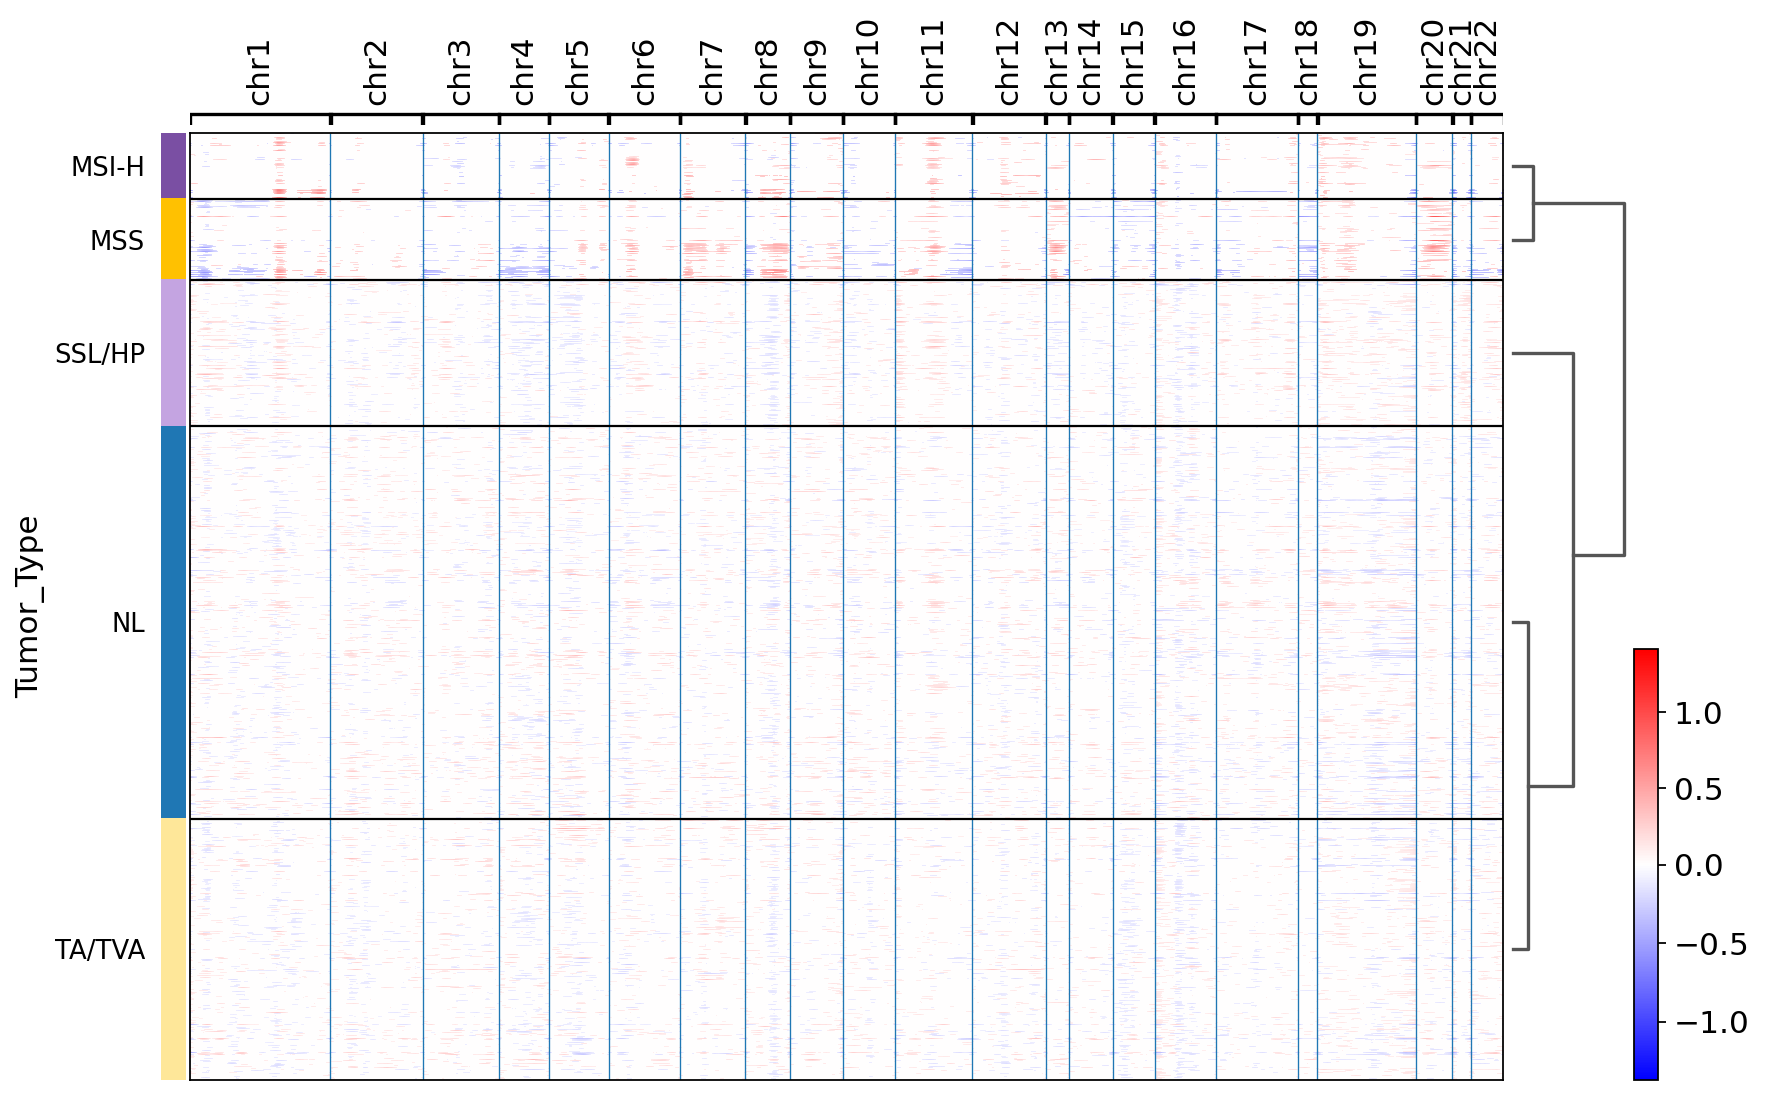

In [43]:
# plot heatmap with tumor type
print("Plotting CNV heatmap with tumor class")
cnv.pl.chromosome_heatmap(
    a_comb,
    groupby="Tumor_Type",
    save="_broad_vumc_comb_epi_tumortype.png",
    dendrogram=True,
    figsize=(12,8),
)

... storing 'HTAN Specimen ID' as categorical
... storing 'Cell_Type' as categorical
... storing 'Polyp_Type' as categorical
... storing 'Sample_Classification' as categorical
... storing 'Patient' as categorical


Plotting CNV heatmap with tumor class
         Falling back to preprocessing with `sc.pp.pca` and default params.
categories: CRC, NL, SSL/HP, etc.
var_group_labels: chr1, chr2, chr3, etc.


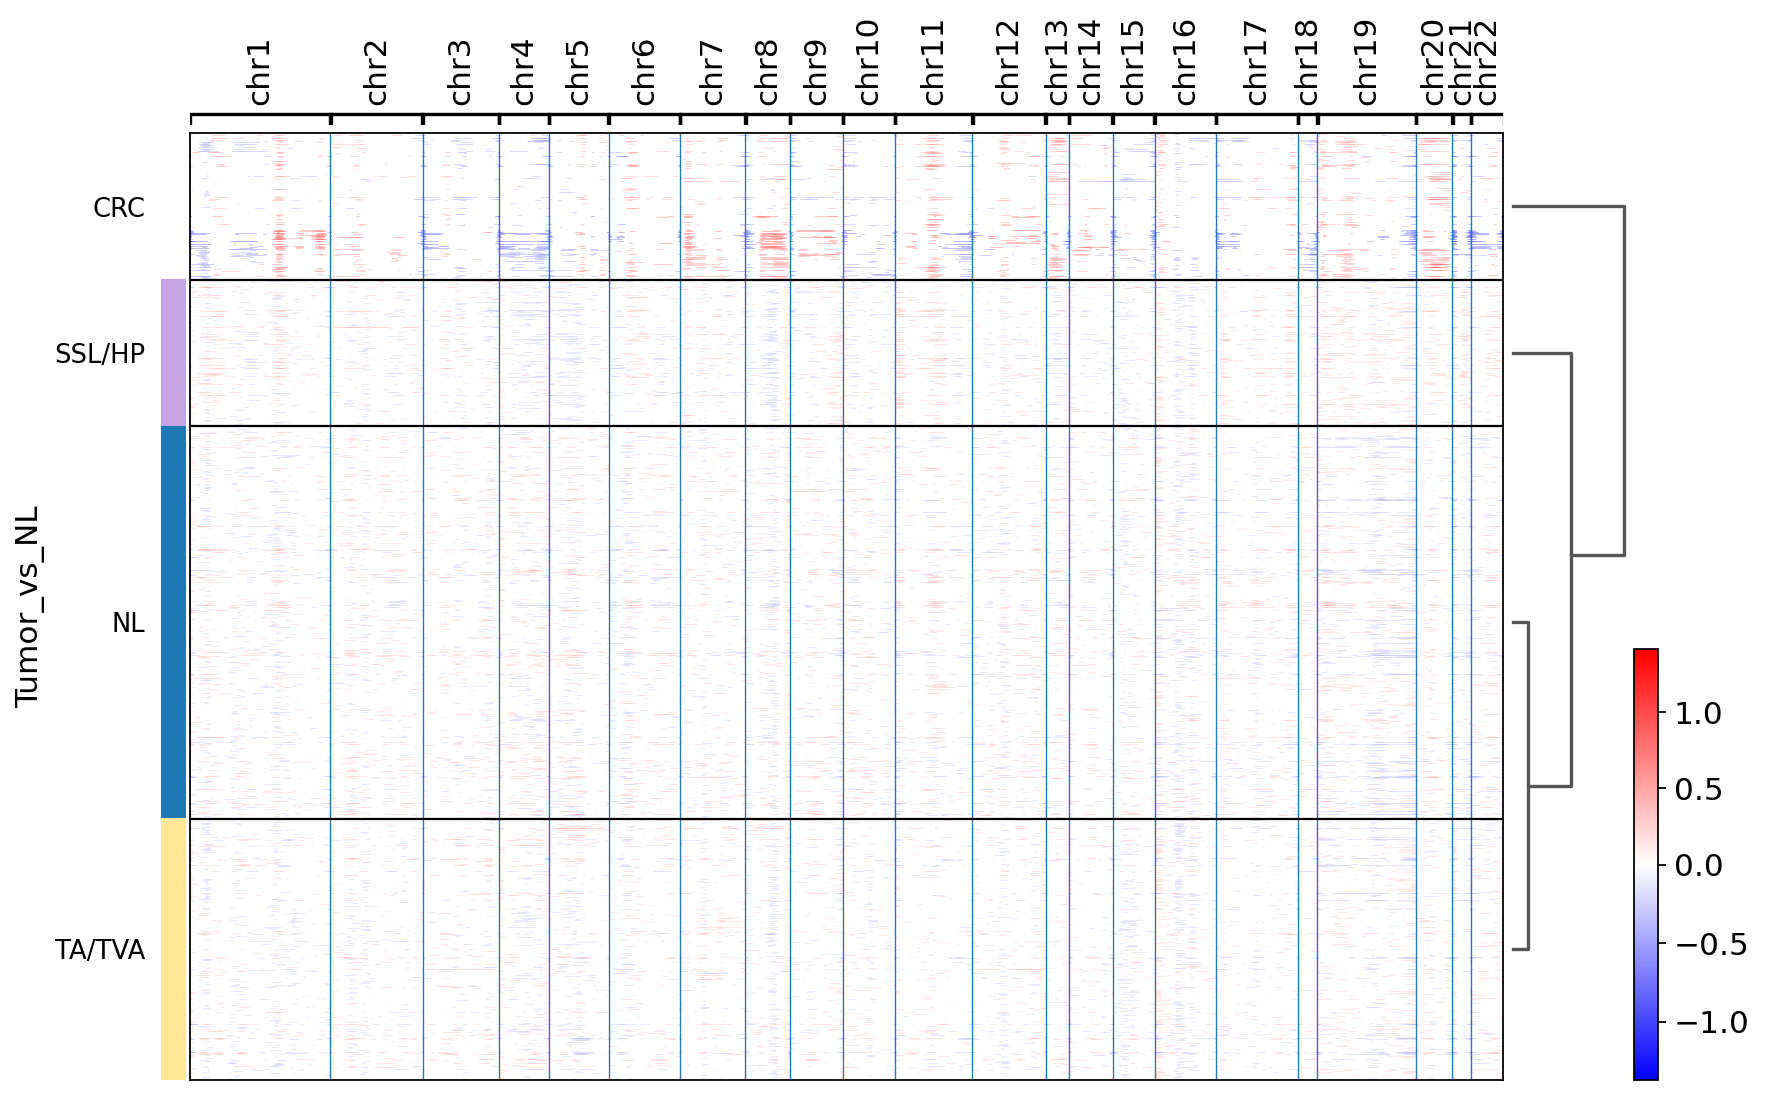

In [66]:
# plot heatmap with tumor type
print("Plotting CNV heatmap with tumor class")
cnv.pl.chromosome_heatmap(
    a_comb,
    groupby="Tumor_vs_NL",
    save="_broad_vumc_comb_epi_tumorvsnl.png",
    dendrogram=True,
    figsize=(12,8),
)

---

In [44]:
import sys; sys.path.append("../../../utility_scripts/")
from boxplot_utils import *

Saving ImSig boxplots for Tumor_Type


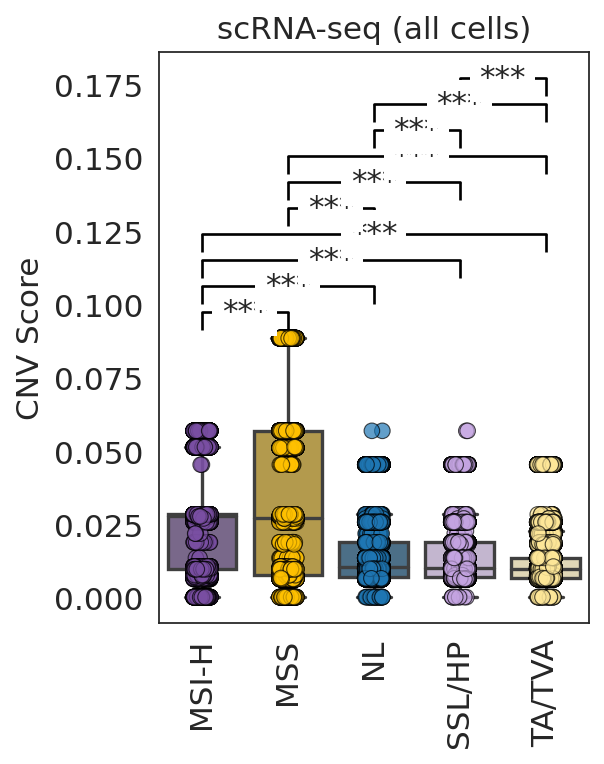

In [50]:
boxplots_group(
    a_comb,
    outdir="scRNA_out/infercnv/",
    obs=["Tumor_Type"],
    colors=["CNV Score"],
    figsize=(4,5),
    sig=True,
    cmap_dict=cmap_dict,
    titles=["scRNA-seq (all cells)"],
)

Saving ImSig boxplots for Tumor_Type


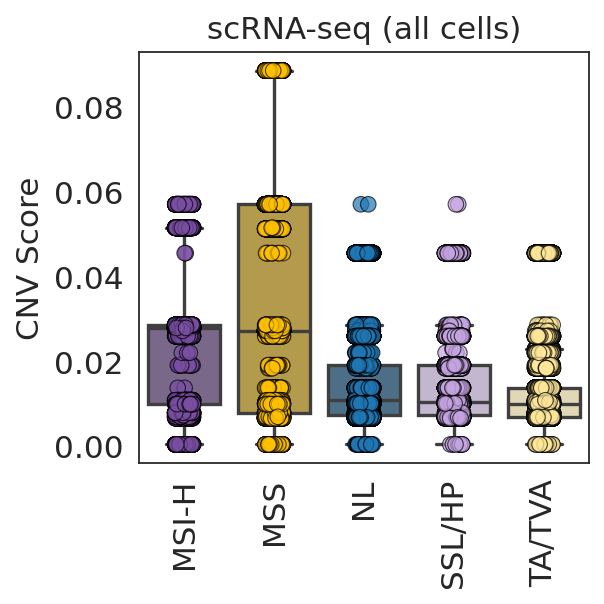

In [51]:
boxplots_group(
    a_comb,
    outdir="scRNA_out/infercnv/",
    obs=["Tumor_Type"],
    colors=["CNV Score"],
    figsize=(4,4),
    sig=False,
    cmap_dict=cmap_dict,
    titles=["scRNA-seq (all cells)"],
)

In [56]:
a_comb.obs.Tumor_Type.value_counts()

NL        31917
TA/TVA    21275
SSL/HP    11896
MSS        6587
MSI-H      5395
Name: Tumor_Type, dtype: int64

In [52]:
a_comb.obs["Tumor_vs_NL"].cat.categories

Index(['CRC', 'NL', 'SSL/HP', 'TA/TVA'], dtype='object')

Saving ImSig boxplots for Tumor_vs_NL


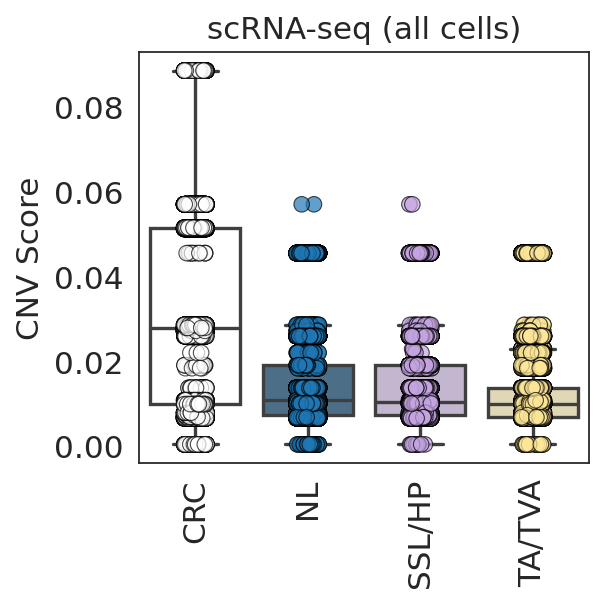

In [53]:
boxplots_group(
    a_comb,
    outdir="scRNA_out/infercnv/",
    obs=["Tumor_vs_NL"],
    colors=["CNV Score"],
    figsize=(4,4),
    sig=False,
    cmap_dict=cmap_dict,
    titles=["scRNA-seq (all cells)"],
)

Saving ImSig boxplots for Tumor_vs_NL


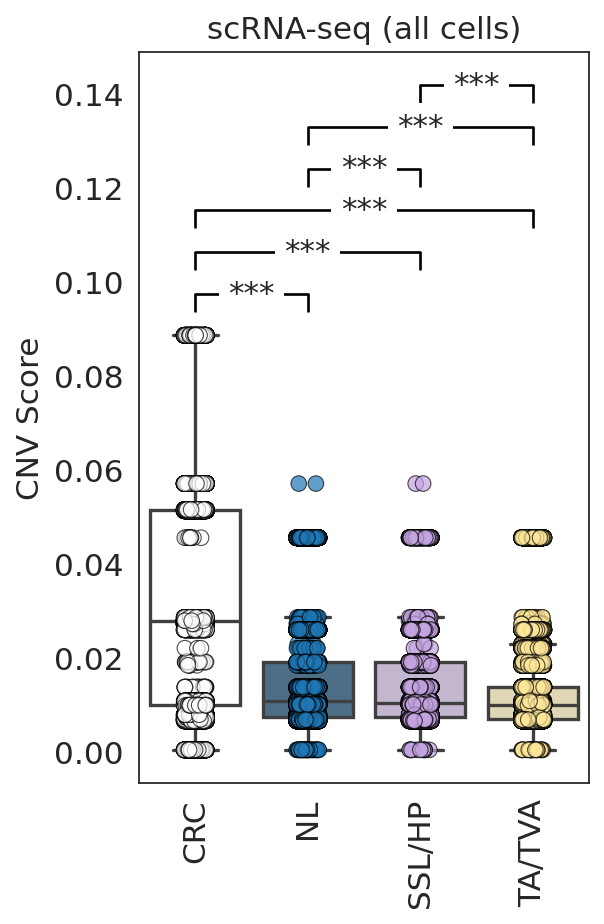

In [54]:
boxplots_group(
    a_comb,
    outdir="scRNA_out/infercnv/",
    obs=["Tumor_vs_NL"],
    colors=["CNV Score"],
    figsize=(4,6),
    sig=True,
    cmap_dict=cmap_dict,
    titles=["scRNA-seq (all cells)"],
)

In [55]:
a_comb.obs.Tumor_vs_NL.value_counts()

NL        31917
TA/TVA    21275
CRC       11982
SSL/HP    11896
Name: Tumor_vs_NL, dtype: int64

---

In [ ]:
# create cnv_leiden colordict
a.obs.cnv_leiden = a.obs.cnv_leiden.astype(str)
a.obs.cnv_leiden = a.obs.cnv_leiden.astype("category")
cnv_leiden_cdict = dict(zip(a.obs.cnv_leiden.cat.categories, sns.color_palette("tab20", len(a.obs.cnv_leiden.cat.categories)).as_hex()))
a.uns["cnv_leiden_colors"] = [cnv_leiden_cdict[x] for x in a.obs.cnv_leiden.cat.categories]

In [ ]:
# plot heatmap with CNV Leiden clusters
print("Plotting CNV heatmap with Leiden clusters")
cnv.pl.chromosome_heatmap(
    a,
    groupby="cnv_leiden",
    save="_VUMC.png",
    dendrogram=True,
    figsize=(12,8),
)

In [ ]:
# plot heatmap with CNV Leiden clusters within each patient cohort
for pat in list(specs.keys()):
    # plot heatmap with patient
    print("Plotting CNV heatmap for {}".format(pat), end=" - ")
    tmp = a[a.obs["Patient"]==pat,:].copy()
    tmp.obs.cnv_leiden = tmp.obs.cnv_leiden.astype(str)
    tmp.obs.cnv_leiden = tmp.obs.cnv_leiden.astype("category")
    tmp.uns["cnv_leiden_colors"] = [cnv_leiden_cdict[x] for x in tmp.obs.cnv_leiden.cat.categories]
    tt = tmp.obs["Tumor_Type"].unique()[0]
    print(tt)
    cnv.pl.chromosome_heatmap(
        tmp,
        groupby="cnv_leiden",
        save="_VUMC_scRNA_{}_{}.png".format(pat, tt.replace("/","-")),
        dendrogram=True,
        figsize=(12,8),
    )

In [ ]:
a.obs.rename(columns={"cnv_score":"CNV Score"}, inplace=True)

---
# Save CNV info to anndatas

In [ ]:
epi_nl = sc.read("../data/scRNA/VUMC_HTAN_DIS_EPI_V2.h5ad")

In [ ]:
stroma = sc.read("../data/scRNA/VUMC_HTAN_VAL_DIS_NONEPI_V2.h5ad")

In [ ]:
epi = sc.read("../data/scRNA/abnormal_epithelium.h5ad")

### Add CNV metadata to UMAP coord anndatas

In [ ]:
epi.obs["Patient"]=np.nan; epi.obs["Tumor_Type"]=np.nan; epi.obs["cnv_leiden"]=np.nan; epi.obs["CNV Score"]=np.nan

epi.obs.loc[
    list(set(a.obs_names).intersection(set(epi.obs_names))),
    ["Patient","Tumor_Type","cnv_leiden","CNV Score"]
] = a.obs.loc[
    list(set(a.obs_names).intersection(set(epi.obs_names))),
    ["Patient","Tumor_Type","cnv_leiden","CNV Score"]
].values

In [ ]:
epi_nl.obs["Patient"]=np.nan; epi_nl.obs["Tumor_Type"]=np.nan; epi_nl.obs["cnv_leiden"]=np.nan; epi_nl.obs["CNV Score"]=np.nan

epi_nl.obs.loc[
    list(set(a.obs_names).intersection(set(epi_nl.obs_names))),
    ["Patient","Tumor_Type","cnv_leiden","CNV Score"]
] = a.obs.loc[
    list(set(a.obs_names).intersection(set(epi_nl.obs_names))),
    ["Patient","Tumor_Type","cnv_leiden","CNV Score"]
].values

In [ ]:
stroma.obs["Patient"]=np.nan; stroma.obs["Tumor_Type"]=np.nan; stroma.obs["cnv_leiden"]=np.nan; stroma.obs["CNV Score"]=np.nan

stroma.obs.loc[
    list(set(a.obs_names).intersection(set(stroma.obs_names))),
    ["Patient","Tumor_Type","cnv_leiden","CNV Score"]
] = a.obs.loc[
    list(set(a.obs_names).intersection(set(stroma.obs_names))),
    ["Patient","Tumor_Type","cnv_leiden","CNV Score"]
].values

In [ ]:
epi_nl.write("../data/scRNA/VUMC_HTAN_DIS_EPI_V2.h5ad", compression="gzip")

In [ ]:
stroma.write("../data/scRNA/VUMC_HTAN_VAL_DIS_NONEPI_V2.h5ad", compression="gzip")

In [ ]:
epi.write("../data/scRNA/abnormal_epithelium.h5ad", compression="gzip")